# Estimation of Demand Function for Train Travel
In this project, we estimated the demand function of train travel by using data on train ticket sales at a particular train station.

## Summary
Treating the demand and supply equations of train travel as a system of two simultaneous equations, we adopted Two-Stage least
squares (2SLS) regression as the primary analytical technique in modeling the demand function. A selfengineered instrumental variable, num_days_ahead, is particularly chosen to solve the endogeneity issue in demand analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# load the data
data = pd.read_csv('Data-GP1.csv')
data.head(5)

,num_seats_total,mean_net_ticket_price,Dept_Date,Purchase_Date,Train_Number_All,Culmulative_sales,isNormCabin,isReturn,isOneway,Customer_Cat
0,1,188.663422,10/9/2019,10/10/2018,A,1,1,0,0,A
1,1,358.428869,5/27/2019,6/6/2018,B,1,0,1,0,A
2,1,356.372684,5/31/2020,6/17/2019,B,1,0,1,0,A
3,1,396.370505,12/10/2019,12/27/2018,C,1,0,1,0,A
4,1,364.264552,5/31/2020,6/19/2019,B,2,0,1,0,A


## Step 1: Data Preprocessing

### X Variables: Feature Engineering

In [3]:
# format datetime object
import datetime
data['Dept_Date'] = pd.to_datetime(data['Dept_Date'])
data['Purchase_Date'] = pd.to_datetime(data['Purchase_Date'])

# num_days_ahead - how many days do the customer purchase ahead of the departure date?
data['num_days_ahead'] = data['Dept_Date'] - data['Purchase_Date']
data['num_days_ahead'] = pd.to_numeric(data['num_days_ahead'].dt.days, downcast='integer')

# Dept_Month (related to seasonality)
data['Dept_Month'] = data['Dept_Date'].dt.month

# Dept_isWeekend (we think this would be related to demand)
data['Dept_DayofWeek'] = data['Dept_Date'].dt.dayofweek
data['Dept_isWeekend'] = np.where(data['Dept_DayofWeek'].isin(['6','5']),1,0)
del data['Dept_DayofWeek']

data.head(5)

,num_seats_total,mean_net_ticket_price,Dept_Date,Purchase_Date,Train_Number_All,Culmulative_sales,isNormCabin,isReturn,isOneway,Customer_Cat,num_days_ahead,Dept_Month,Dept_isWeekend
0,1,188.663422,2019-10-09,2018-10-10,A,1,1,0,0,A,364,10,0
1,1,358.428869,2019-05-27,2018-06-06,B,1,0,1,0,A,355,5,0
2,1,356.372684,2020-05-31,2019-06-17,B,1,0,1,0,A,349,5,1
3,1,396.370505,2019-12-10,2018-12-27,C,1,0,1,0,A,348,12,0
4,1,364.264552,2020-05-31,2019-06-19,B,2,0,1,0,A,347,5,1


### Y Variable

In [4]:
def calulate(df):
    # calculate cumulative_sales by price - as demand
    df = df.sort_values(by='mean_net_ticket_price', ascending=False)
    df['cumulative_sales'] = df['num_seats_total'].cumsum()
    
    # calculate cumulative past sales by date - as X variable/IV
    df = df.sort_values(by='Purchase_Date', ascending=True)
    df['past_sales'] = df['num_seats_total'].cumsum()
    
    return df

data = data.groupby(['Train_Number_All', 'Dept_Date']).apply(calulate)
data['past_sales'] = data['past_sales'] - data['num_seats_total']

data.head(5)

num_seats_total  mean_net_ticket_price  \
Train_Number_All Dept_Date                                                   
A                2018-06-01 47196                 1             418.084961   
                 2018-06-02 207766                1             464.041601   
                 2018-06-03 44629                 4             561.181241   
                            46277                 1             633.715657   
                            208931                2             763.550821   

                                    Dept_Date Purchase_Date Train_Number_All  \
Train_Number_All Dept_Date                                                     
A                2018-06-01 47196  2018-06-01    2018-06-01                A   
                 2018-06-02 207766 2018-06-02    2018-06-01                A   
                 2018-06-03 44629  2018-06-03    2018-06-01                A   
                            46277  2018-06-03    2018-06-02                A   
                            208931 2018-06-03    2018-06-03                A   

                                    Culmulative_sales  isNormCabin  isReturn  \
Train_Number_All Dept_Date                                                     
A                2018-06-01 47196                   1            0         0   
                 2018-06-02 207766                  1            0         0   
                 2018-06-03 44629                   4            0         0   
                            46277                   5            0         0   
                            208931                  2            0         0   

                                    isOneway Customer_Cat  num_days_ahead  \
Train_Number_All Dept_Date                                                  
A                2018-06-01 47196          0            A               0   
                 2018-06-02 207766         0            B               1   
                 2018-06-03 44629          0            A               2   
                            46277          0            A               1   
                            208931         1            B               0   

                                    Dept_Month  Dept_isWeekend  \
Train_Number_All Dept_Date                                       
A                2018-06-01 47196            6               0   
                 2018-06-02 207766           6               1   
                 2018-06-03 44629            6               1   
                            46277            6               1   
                            208931           6               1   

                                    cumulative_sales  past_sales  
Train_Number_All Dept_Date                                        
A                2018-06-01 47196                  1           0  
                 2018-06-02 207766                 1           0  
                 2018-06-03 44629                  7           0  
                            46277                  3           4  
                            208931                 2           5

In [146]:
data.reset_index(drop=True, inplace=True)
data.head(10)

,num_seats_total,mean_net_ticket_price,Dept_Date,Purchase_Date,Train_Number_All,isNormCabin,isReturn,isOneway,Customer_Cat,num_days_ahead,Dept_Month,Dept_isWeekend,cumulative_sales,past_sales
0,1,418.084961,2018-06-01,2018-06-01,A,0,0,0,A,0,6,0,1,0
1,1,464.041601,2018-06-02,2018-06-01,A,0,0,0,B,1,6,1,1,0
2,4,561.181241,2018-06-03,2018-06-01,A,0,0,0,A,2,6,1,7,0
3,1,633.715657,2018-06-03,2018-06-02,A,0,0,0,A,1,6,1,3,4
4,2,763.550821,2018-06-03,2018-06-03,A,0,0,1,B,0,6,1,2,5
5,4,546.920747,2018-06-04,2018-06-01,A,0,0,0,A,3,6,0,4,0
6,2,463.712934,2018-06-04,2018-06-02,A,0,0,0,B,2,6,0,7,4
7,1,466.329515,2018-06-04,2018-06-03,A,0,0,0,B,1,6,0,5,6
8,1,403.821451,2018-06-04,2018-06-03,A,0,0,1,B,1,6,0,8,7
9,1,417.549503,2018-06-05,2018-06-01,A,0,0,0,A,4,6,0,5,0


In [120]:
# download the csv
from IPython.display import FileLink, FileLinks
data.to_csv('data_processed.csv', index=False)

## Step 2: Exploratory Data Analysis
visualization - univariate analysis

time series plot, box plot, by color

report the summary statistics (mean, max, min, variance, ...)

In [61]:
import seaborn as sns
import statsmodels
import fastcluster

## Histograms

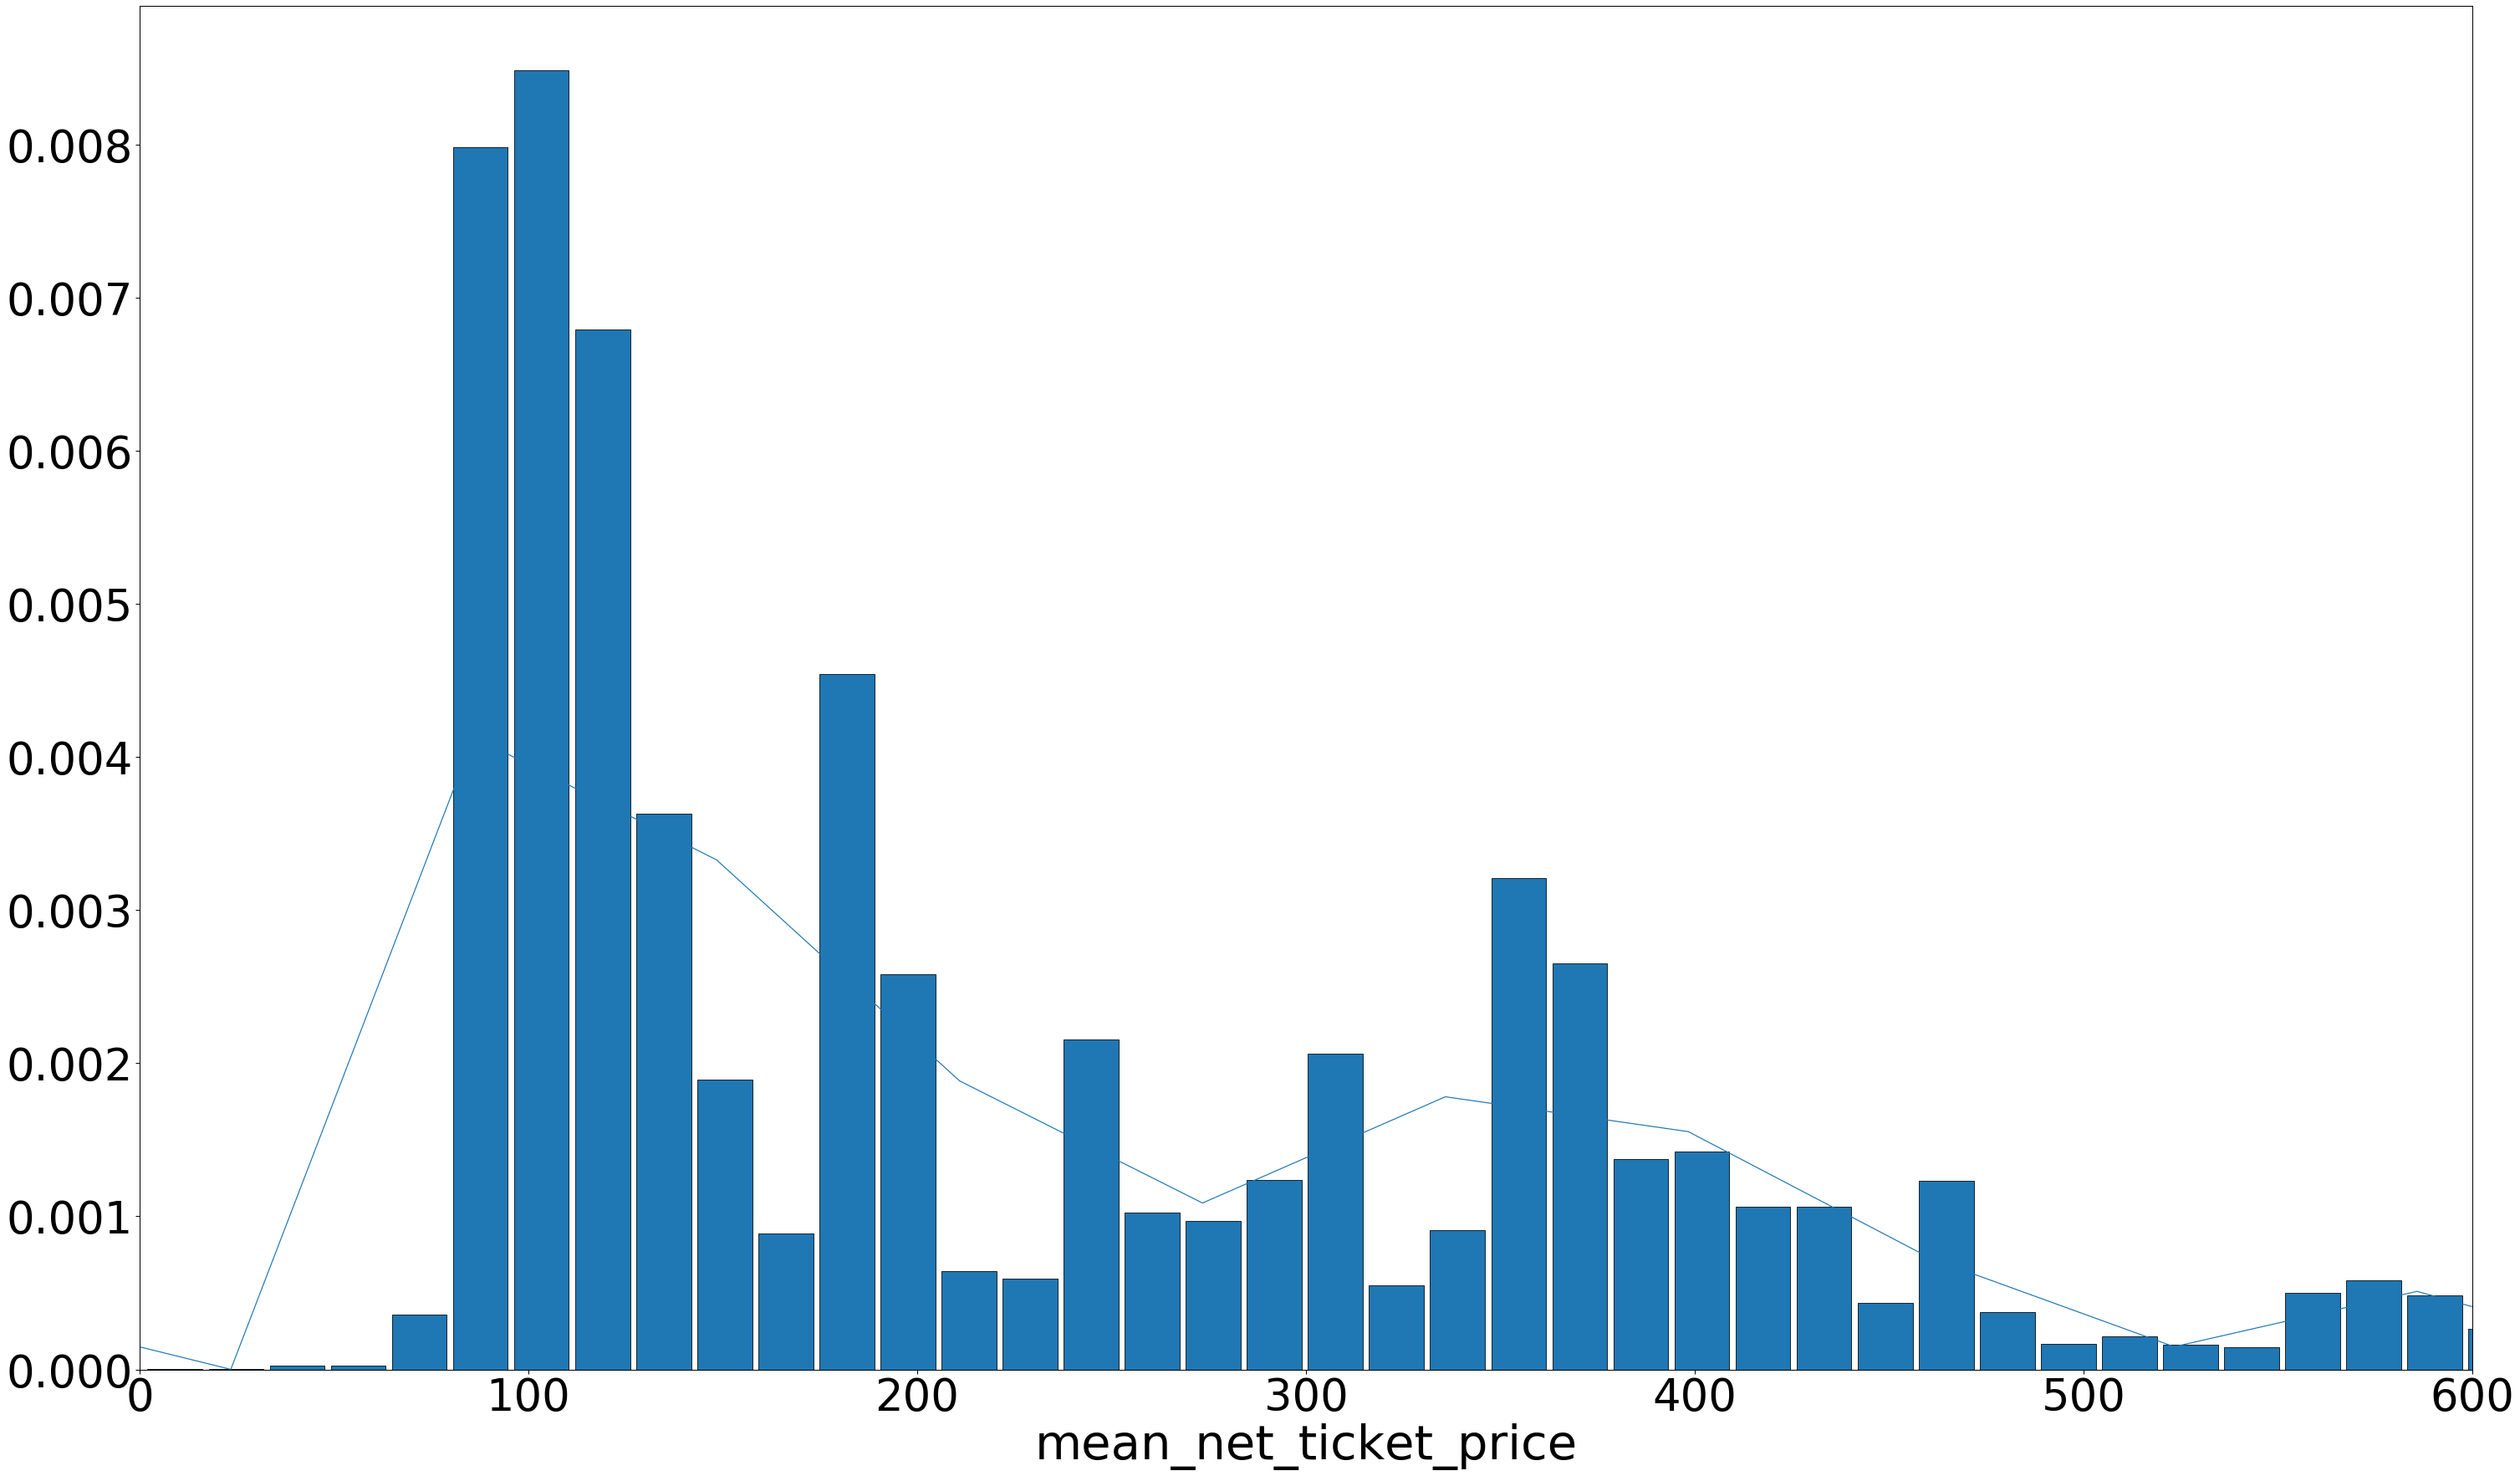

In [63]:
# univariate histogram
plt.figure(figsize=(50,30))
sns.set_color_codes()
sns.set_context("paper", font_scale=6) 
sns.distplot(data["mean_net_ticket_price"], bins=500, hist_kws={"edgecolor":"black","rwidth":0.9, 'alpha':1.0}, hist=True)

plt.xlim(0, 600) # impose a cutoff at 600, there's few data points beyond 600

plt.savefig('histogram.jpg')

/Users/lg/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:335: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds,


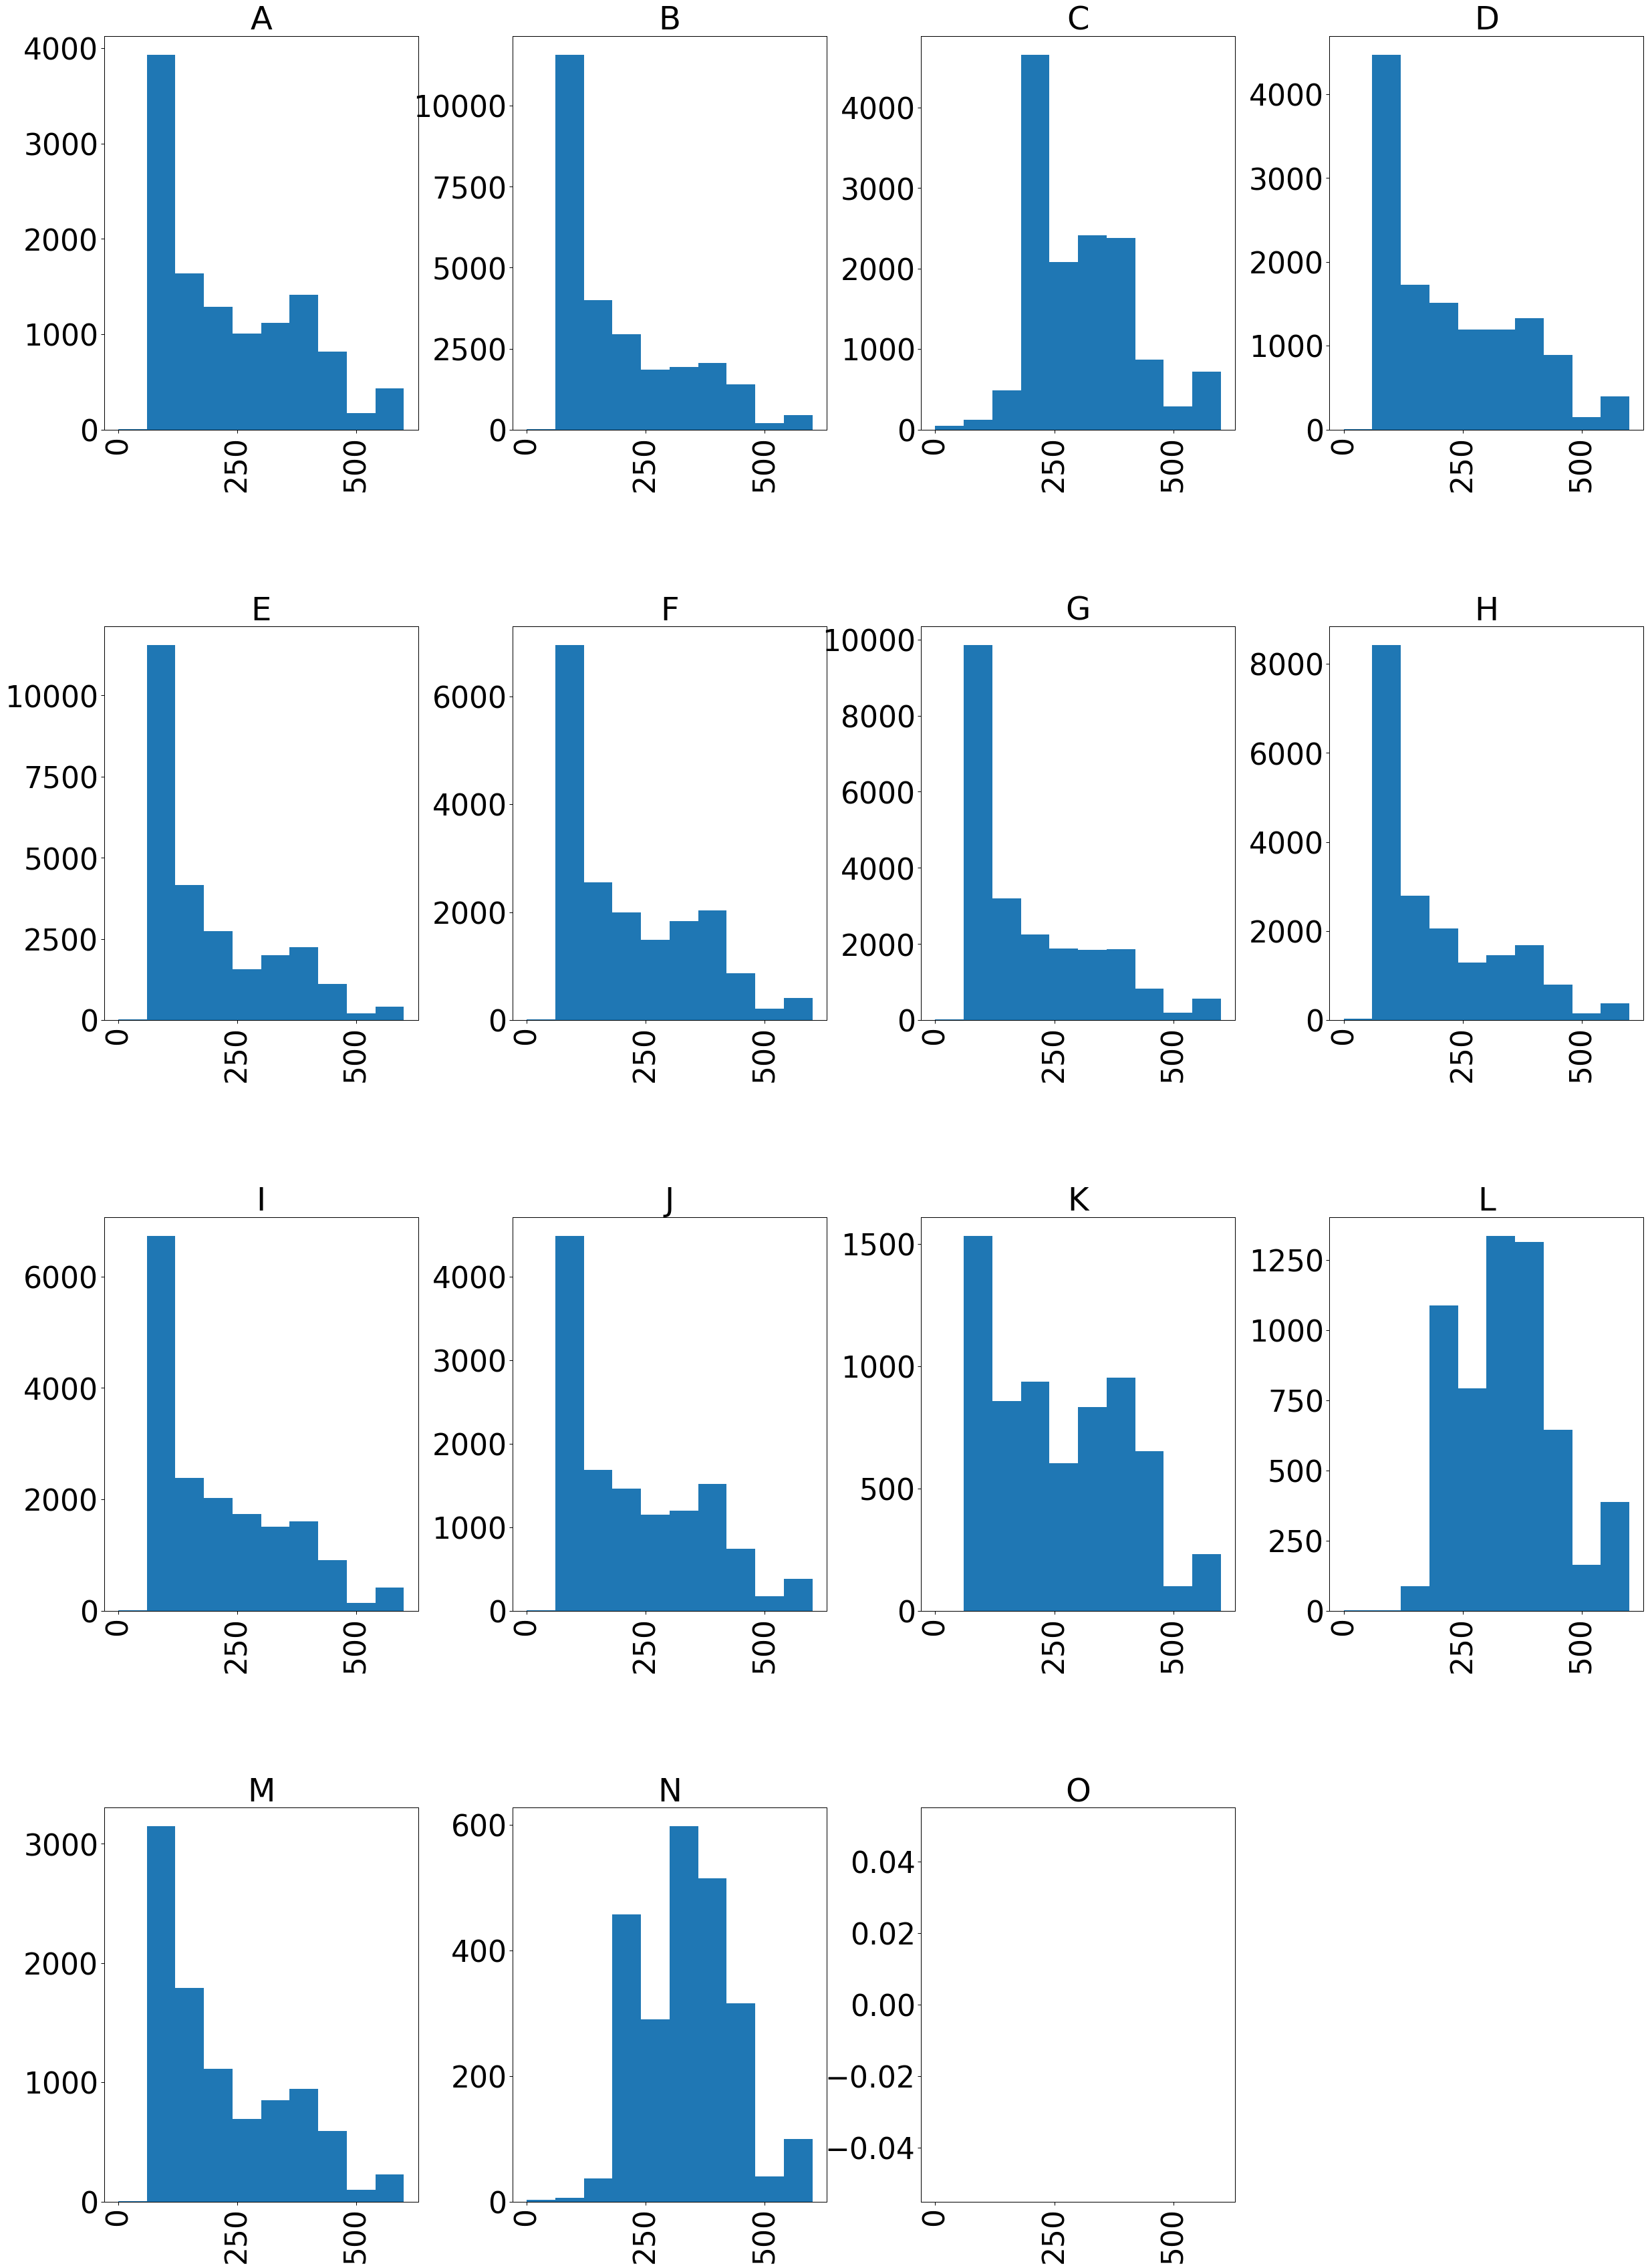

In [64]:
# univariate histogram: mean_net_ticket_price by Train_Number_All
# impose a cutoff at 600, there's few data points beyond 600 -> make it comparable and more readable

fig = plt.figure(figsize = (40,60))
ax = fig.gca()
sns.set_context("paper", font_scale=5) 
data['mean_net_ticket_price'].hist(by=data['Train_Number_All'], ax=ax, range=(0, 600))
plt.savefig('histogram2.jpg')

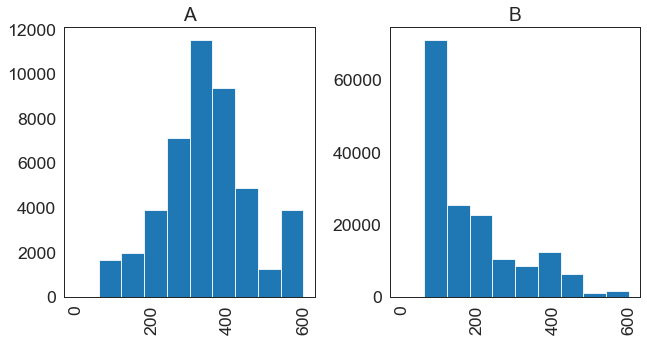

In [248]:
# univariate histogram: mean_net_ticket_price by Customer_Cat
# impose a cutoff at 600, there's few data points beyond 600 -> make it comparable and more readable

fig = plt.figure(figsize = (10,5))
ax = fig.gca()
sns.set_context("paper", font_scale=2) 
data['mean_net_ticket_price'].hist(by=data['Customer_Cat'], ax=ax, range=(0, 600))
plt.savefig('histogram3.jpg')

#### Observations:
The distribution of mean_net_ticket_price of the train tickets bought by customer category A/B varies a lot.
(but this doesn't has any indication on robustness, just an interesting observation).

## Correlation

In [69]:
# correlation - bivariate analysis
from scipy.stats import pearsonr

print('cumulative_sales vs. mean_net_ticket_price:')
print('Correlation: ', '{:f}'.format(np.cov(data["cumulative_sales"],data["mean_net_ticket_price"])[0][1]))
corr, _ = pearsonr(data["cumulative_sales"],data["mean_net_ticket_price"])
print("Pearson's correlation: %.3f" % corr)

print('\n')

print('cumulative_sales vs. num_days_ahead:')
print('Correlation: ', '{:f}'.format(np.cov(data["cumulative_sales"],data["num_days_ahead"])[0][1]))
corr, _ = pearsonr(data["cumulative_sales"],data["num_days_ahead"])
print("Pearson's correlation: %.3f" % corr)

print('\n')

print('cumulative_sales vs past_sales:')
corr, _ = pearsonr(data["cumulative_sales"],data["past_sales"])
print('Correlation: ', '{:f}'.format(np.cov(data["cumulative_sales"],data["past_sales"])[0][1]))
print("Pearson's correlation: %.3f" % corr)

print('\n')

print('price vs past_sales:')
corr, _ = pearsonr(data["mean_net_ticket_price"],data["past_sales"])
print('Correlation: ', '{:f}'.format(np.cov(data["mean_net_ticket_price"],data["past_sales"])[0][1]))
print("Pearson's correlation: %.3f" % corr)

cumulative_sales vs. mean_net_ticket_price:
Correlation:  -3452.063086
Pearson's correlation: -0.522


cumulative_sales vs. num_days_ahead:
Correlation:  907.227627
Pearson's correlation: 0.310


cumulative_sales vs past_sales:
Correlation:  23.715088
Pearson's correlation: 0.011


price vs past_sales:
Correlation:  1841.324140
Pearson's correlation: 0.250


#### Pearson's Correlation
* The Pearson correlation coefficient (named for Karl Pearson) can be used to summarize the strength of the linear relationship between two data samples.

* The Pearson’s correlation coefficient is calculated as the covariance of the two variables divided by the product of the standard deviation of each data sample. It is the normalization of the covariance between the two variables to give an interpretable score.

* The use of mean and standard deviation in the calculation suggests the need for the two data samples to have a Gaussian or Gaussian-like distribution.

* The result of the calculation, the correlation coefficient can be interpreted to understand the relationship.

* The coefficient returns a value between -1 and 1 that represents the limits of correlation from a full negative correlation to a full positive correlation. A value of 0 means no correlation. The value must be interpreted, where often a value below -0.5 or above 0.5 indicates a notable correlation, and values below those values suggests a less notable correlation.

#### One-way ANOVA test:

The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean. The test is applied to samples from two or more groups, possibly with differing sizes.

*reference:* https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html

In [79]:
# ANOVA test - bivariate analysis
import researchpy as rp
rp.summary_cont(data['cumulative_sales'].groupby(data['Customer_Cat']))

,N,Mean,SD,SE,95% Conf.,Interval
Customer_Cat,,,,,,
A,47293,25.8237,24.1181,0.1109,25.6063,26.0411
B,162404,53.9343,47.5423,0.1180,53.7030,54.1655


In [78]:
# one-way ANOVA: cumulative_sales vs Customer_Cat
from scipy.stats import f_oneway

F, p = f_oneway(data.loc[data['Customer_Cat'] == 'A']['cumulative_sales'], data.loc[data['Customer_Cat'] == 'B']['cumulative_sales'])
print('F statistics: ', F, '\np-value: ', p)

F statistics:  15381.152969369901 
p-value:  0.0


#### Conclusion:

Then we reject the null hypothesis -> The population means of these two groups are statistically different.

In [146]:
rp.summary_cont(data['cumulative_sales'].groupby(data['Dept_isWeekend']))

,N,Mean,SD,SE,95% Conf.,Interval
Dept_isWeekend,,,,,,
0,151118,48.230,45.0126,0.1158,48.0031,48.4570
1,58579,45.955,44.7154,0.1848,45.5929,46.3171


In [81]:
# one-way ANOVA: cumulative_sales vs Dept_isWeekend
F, p = f_oneway(data.loc[data['Dept_isWeekend'] == 1]['cumulative_sales'], data.loc[data['Dept_isWeekend'] == 0]['cumulative_sales'])
print('F statistics: ', F, '\np-value: ', p)

F statistics:  108.23738431889686 
p-value:  2.418542109655855e-25


#### Conclusion:

Then we accept the null hypothesis -> The population means of these two groups are not statistically different.

In [147]:
rp.summary_cont(data['cumulative_sales'].groupby(data['Dept_Month']))

,N,Mean,SD,SE,95% Conf.,Interval
Dept_Month,,,,,,
1,17457,50.9490,46.3131,0.3505,50.2620,51.6361
2,12288,47.8799,47.8867,0.4320,47.0331,48.7267
3,19415,66.8260,57.3797,0.4118,66.0188,67.6332
4,14230,55.3182,48.2563,0.4045,54.5253,56.1111
5,16999,55.1018,48.6959,0.3735,54.3697,55.8339
6,20547,52.2875,52.8499,0.3687,51.5649,53.0102
7,18406,33.2404,32.1876,0.2373,32.7754,33.7054
8,15123,33.6046,33.5876,0.2731,33.0692,34.1399
9,16790,37.4877,33.3249,0.2572,36.9836,37.9918


In [86]:
# one-way ANOVA: cumulative_sales vs Dept_Month
F, p = f_oneway(data.loc[data['Dept_Month'] == 1]['cumulative_sales'], data.loc[data['Dept_Month'] == 2]['cumulative_sales'],
               data.loc[data['Dept_Month'] == 3]['cumulative_sales'], data.loc[data['Dept_Month'] == 4]['cumulative_sales'],
               data.loc[data['Dept_Month'] == 5]['cumulative_sales'], data.loc[data['Dept_Month'] == 6]['cumulative_sales'],
               data.loc[data['Dept_Month'] == 7]['cumulative_sales'], data.loc[data['Dept_Month'] == 8]['cumulative_sales'],
               data.loc[data['Dept_Month'] == 9]['cumulative_sales'], data.loc[data['Dept_Month'] == 10]['cumulative_sales'],
               data.loc[data['Dept_Month'] == 11]['cumulative_sales'], data.loc[data['Dept_Month'] == 12]['cumulative_sales'])
print('F statistics: ', F, '\np-value: ', p)

F statistics:  885.9221286271322 
p-value:  0.0


#### Conclusion:

Then we reject the null hypothesis -> Not all the population means of these groups are the same.

In [89]:
#rp.summary_cat(data[[ "Train_Number_All", "Customer_Cat"]])

In [91]:
# the expensive ticket (leverage point)
data.loc[data['mean_net_ticket_price'] > 5000]

,num_seats_total,mean_net_ticket_price,Dept_Date,Purchase_Date,Train_Number_All,isNormCabin,isReturn,isOneway,Customer_Cat,num_days_ahead,Dept_Month,Dept_isWeekend,cumulative_sales,past_sales
56245,1,7855.766106,2018-10-23,2018-10-22,D,0,0,1,A,1,10,0,1,60


In [94]:
# the expensive tickets
data.loc[data['mean_net_ticket_price'] > 1500]

,num_seats_total,mean_net_ticket_price,Dept_Date,Purchase_Date,Train_Number_All,isNormCabin,isReturn,isOneway,Customer_Cat,num_days_ahead,Dept_Month,Dept_isWeekend,cumulative_sales,past_sales
39283,1,1701.558448,2018-07-02,2018-07-02,C,0,0,1,A,0,7,0,1,34
56245,1,7855.766106,2018-10-23,2018-10-22,D,0,0,1,A,1,10,0,1,60


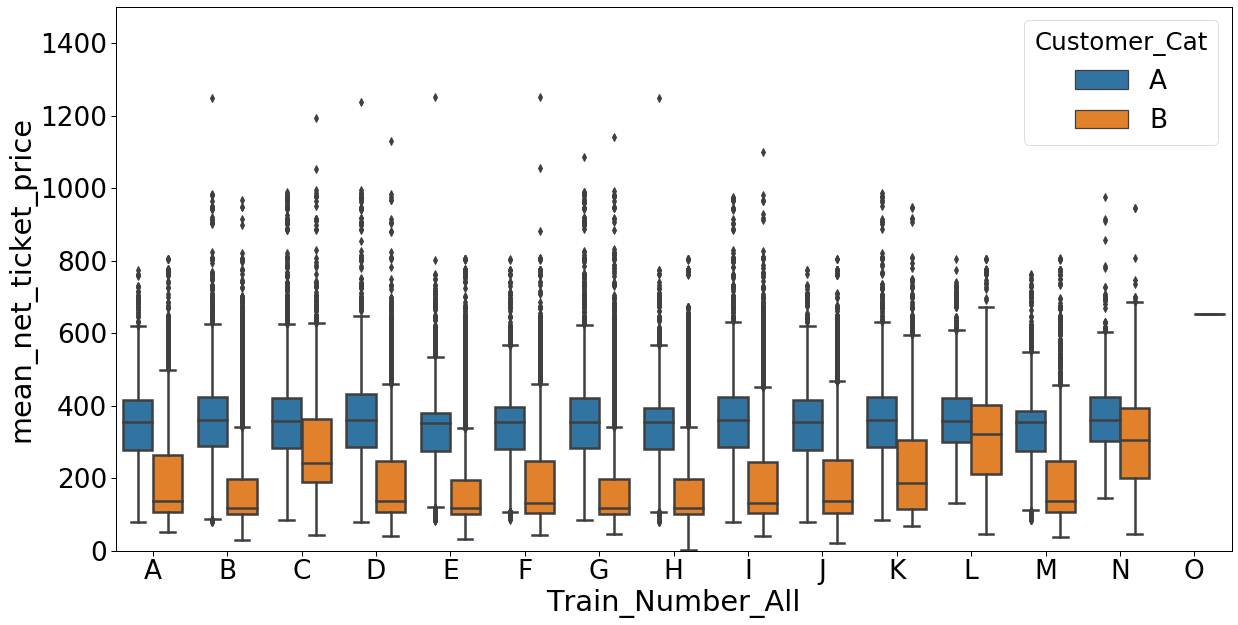

In [93]:
# box plot - bivariate analysis

plt.figure(figsize=(20,10))
sns.set_context("paper", font_scale=3)  
ax = sns.boxplot(x="Train_Number_All", y="mean_net_ticket_price", 
                 data=data, linewidth=2.5, hue="Customer_Cat") # show the datapoints on top of the boxes
plt.ylim(0, 1500) # here we did not include the most expensive tickets for visualization purpose
plt.savefig('box_plot.jpg')

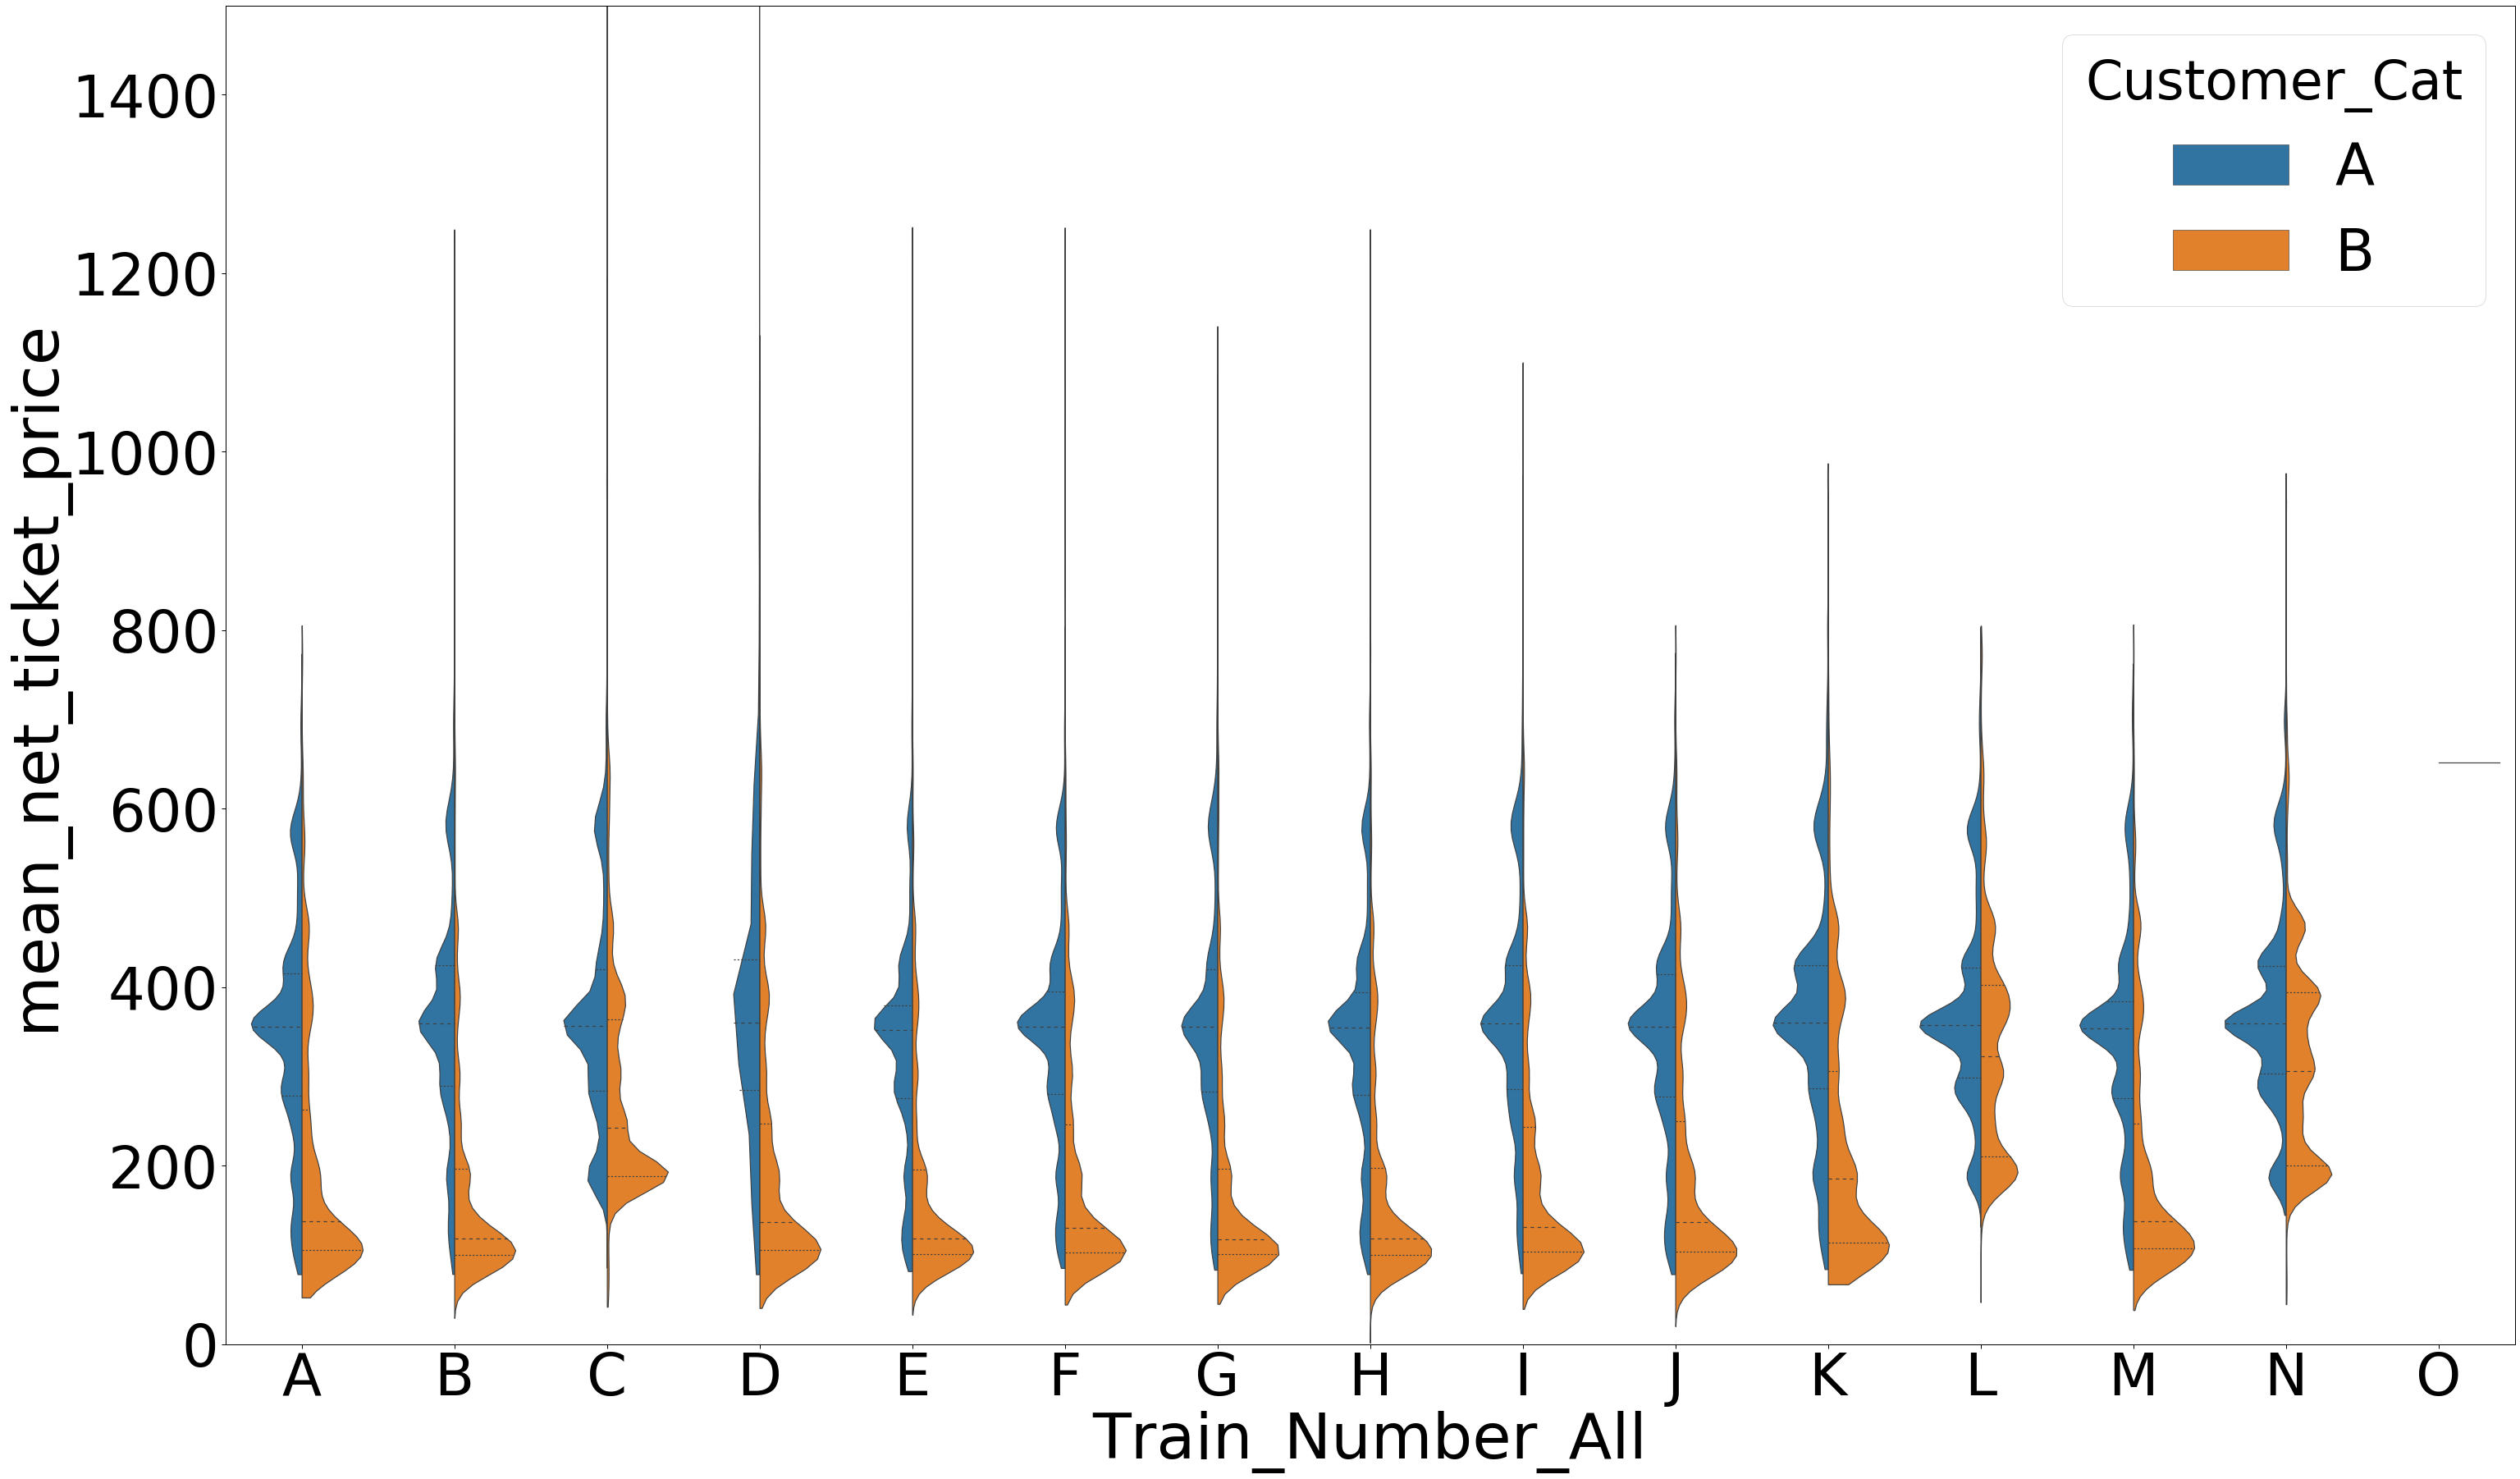

In [97]:
# violin plot - similar to the graph above, just another form
plt.figure(figsize=(50,30))
sns.set_context("paper", font_scale=8)  
ax = sns.violinplot(x="Train_Number_All", y="mean_net_ticket_price", hue="Customer_Cat",
            kind="violin", bw=.15, cut=0,
            data=data, split=True,inner="quartile")
plt.ylim(0, 1500) # here we did not include the most expensive tickets for visualization purpose
plt.savefig('violin_plot.jpg')

#### Observations:
On average, the mean of mean_net_ticket_price of the tickets bought by customer category A is higher than customer category B.
(Ps. but this doesn't has any indication on robustness, just an interesting observation).

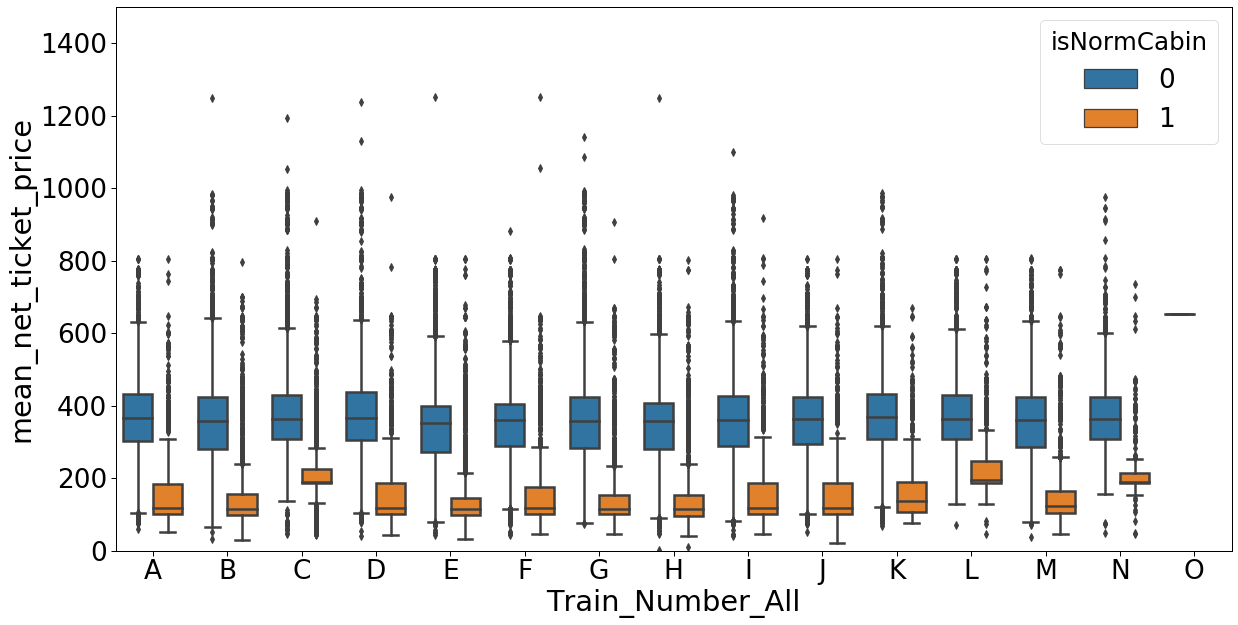

In [96]:
# box plot - bivariate analysis

plt.figure(figsize=(20,10))
sns.set_context("paper", font_scale=3)  
ax = sns.boxplot(x="Train_Number_All", y="mean_net_ticket_price", 
                 data=data, linewidth=2.5, hue="isNormCabin") # show the datapoints on top of the boxes
plt.ylim(0, 1500) # here we did not include the most expensive tickets for visualization purpose
plt.savefig('box_plot2.jpg')

#### Observations:
On average, the mean of mean_net_ticket_price of the tickets of normal cabin is lower than that of non-normal cabin.
(Ps. but this doesn't has any indication on robustness, just an interesting observation).

## Step 3: Modeling

In [132]:
from statsmodels.api import add_constant
from linearmodels.iv import IV2SLS

In [133]:
# train/test split (use time as cut-off point)

## OLS

In [147]:
df = add_constant(data, has_constant='add')
df

,const,num_seats_total,mean_net_ticket_price,Dept_Date,Purchase_Date,Train_Number_All,isNormCabin,isReturn,isOneway,Customer_Cat,num_days_ahead,Dept_Month,Dept_isWeekend,cumulative_sales,past_sales
0,1.0,1,418.084961,2018-06-01,2018-06-01,A,0,0,0,A,0,6,0,1,0
1,1.0,1,464.041601,2018-06-02,2018-06-01,A,0,0,0,B,1,6,1,1,0
2,1.0,4,561.181241,2018-06-03,2018-06-01,A,0,0,0,A,2,6,1,7,0
3,1.0,1,633.715657,2018-06-03,2018-06-02,A,0,0,0,A,1,6,1,3,4
4,1.0,2,763.550821,2018-06-03,2018-06-03,A,0,0,1,B,0,6,1,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209692,1.0,4,224.492827,2020-01-26,2019-03-14,N,1,0,0,B,318,1,1,6,2
209693,1.0,4,223.217609,2020-01-26,2019-05-14,N,0,1,0,B,257,1,1,10,6
209694,1.0,2,222.175613,2020-01-26,2019-05-21,N,1,1,0,B,250,1,1,12,10
209695,1.0,2,225.402752,2020-01-26,2019-06-24,N,1,0,0,B,216,1,1,2,12


In [148]:
regout = IV2SLS(df[['cumulative_sales']], df[['const', 'mean_net_ticket_price']], None, None).fit(cov_type='unadjusted')
regout

OLS Estimation Summary                            
==============================================================================
Dep. Variable:       cumulative_sales   R-squared:                      0.2730
Estimator:                        OLS   Adj. R-squared:                 0.2729
No. Observations:              209697   F-statistic:                 7.873e+04
Date:                Tue, Sep 22 2020   P-value (F-stat)                0.0000
Time:                        19:26:37   Distribution:                  chi2(1)
Cov. Estimator:            unadjusted                                         
                                                                              
                                   Parameter Estimates                                   
=========================================================================================
                       Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------------
const                     84.344     0.1554     542.66     0.0000      84.039      84.648
mean_net_ticket_price    -0.1597     0.0006    -280.58     0.0000     -0.1608     -0.1586
=========================================================================================
OLSResults, id: 0x11b91fe90

In [149]:
# covariance matrix
df['res'] = regout.resids
cov_y2res = np.cov(df['mean_net_ticket_price'],df['res'])
cov_y2res

array([[2.16162872e+04, 1.59959619e-12],
       [1.59959619e-12, 1.46843337e+03]])

In [150]:
# correlation matrix
cor_y2res = np.corrcoef(df['mean_net_ticket_price'],df['res'])
cor_y2res

array([[1.00000000e+00, 2.83917843e-16],
       [2.83917843e-16, 1.00000000e+00]])

#### Observation:
In OLS, the correlation between mean_net_ticket_price and the residual is 2.83917843e-16.

## 2-Stage Least Squares

In [151]:
regout1 = IV2SLS(df[['cumulative_sales']], df[['const']], df[['mean_net_ticket_price']], df[['past_sales']]).fit(cov_type='unadjusted')
regout1

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:       cumulative_sales   R-squared:                     -0.0458
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0458
No. Observations:              209697   F-statistic:                    22.213
Date:                Tue, Sep 22 2020   P-value (F-stat)                0.0000
Time:                        19:26:38   Distribution:                  chi2(1)
Cov. Estimator:            unadjusted                                         
                                                                              
                                   Parameter Estimates                                   
=========================================================================================
                       Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------------
const                     44.631     0.6368     70.086     0.0000      43.383      45.879
mean_net_ticket_price     0.0129     0.0027     4.7131     0.0000      0.0075      0.0182
=========================================================================================

Endogenous: mean_net_ticket_price
Instruments: past_sales
Unadjusted Covariance (Homoskedastic)
Debiased: False
IVResults, id: 0x104016bd0

In [152]:
from statsmodels.formula.api import ols
import scipy

from sklearn.metrics import r2_score

In [153]:
df['ln_cumulative_sales'] = np.log(df['cumulative_sales']) 
df['ln_mean_net_ticket_price'] = np.log(df['mean_net_ticket_price']) 

In [154]:
df.head()

,const,num_seats_total,mean_net_ticket_price,Dept_Date,Purchase_Date,Train_Number_All,isNormCabin,isReturn,isOneway,Customer_Cat,num_days_ahead,Dept_Month,Dept_isWeekend,cumulative_sales,past_sales,res,ln_cumulative_sales,ln_mean_net_ticket_price
0,1.0,1,418.084961,2018-06-01,2018-06-01,A,0,0,0,A,0,6,0,1,0,-16.576482,0.000000,6.035685
1,1.0,1,464.041601,2018-06-02,2018-06-01,A,0,0,0,B,1,6,1,1,0,-9.237330,0.000000,6.139974
2,1.0,4,561.181241,2018-06-03,2018-06-01,A,0,0,0,A,2,6,1,7,0,12.275610,1.945910,6.330044
3,1.0,1,633.715657,2018-06-03,2018-06-02,A,0,0,0,A,1,6,1,3,4,19.859162,1.098612,6.451600
4,1.0,2,763.550821,2018-06-03,2018-06-03,A,0,0,1,B,0,6,1,2,5,39.593489,0.693147,6.637980


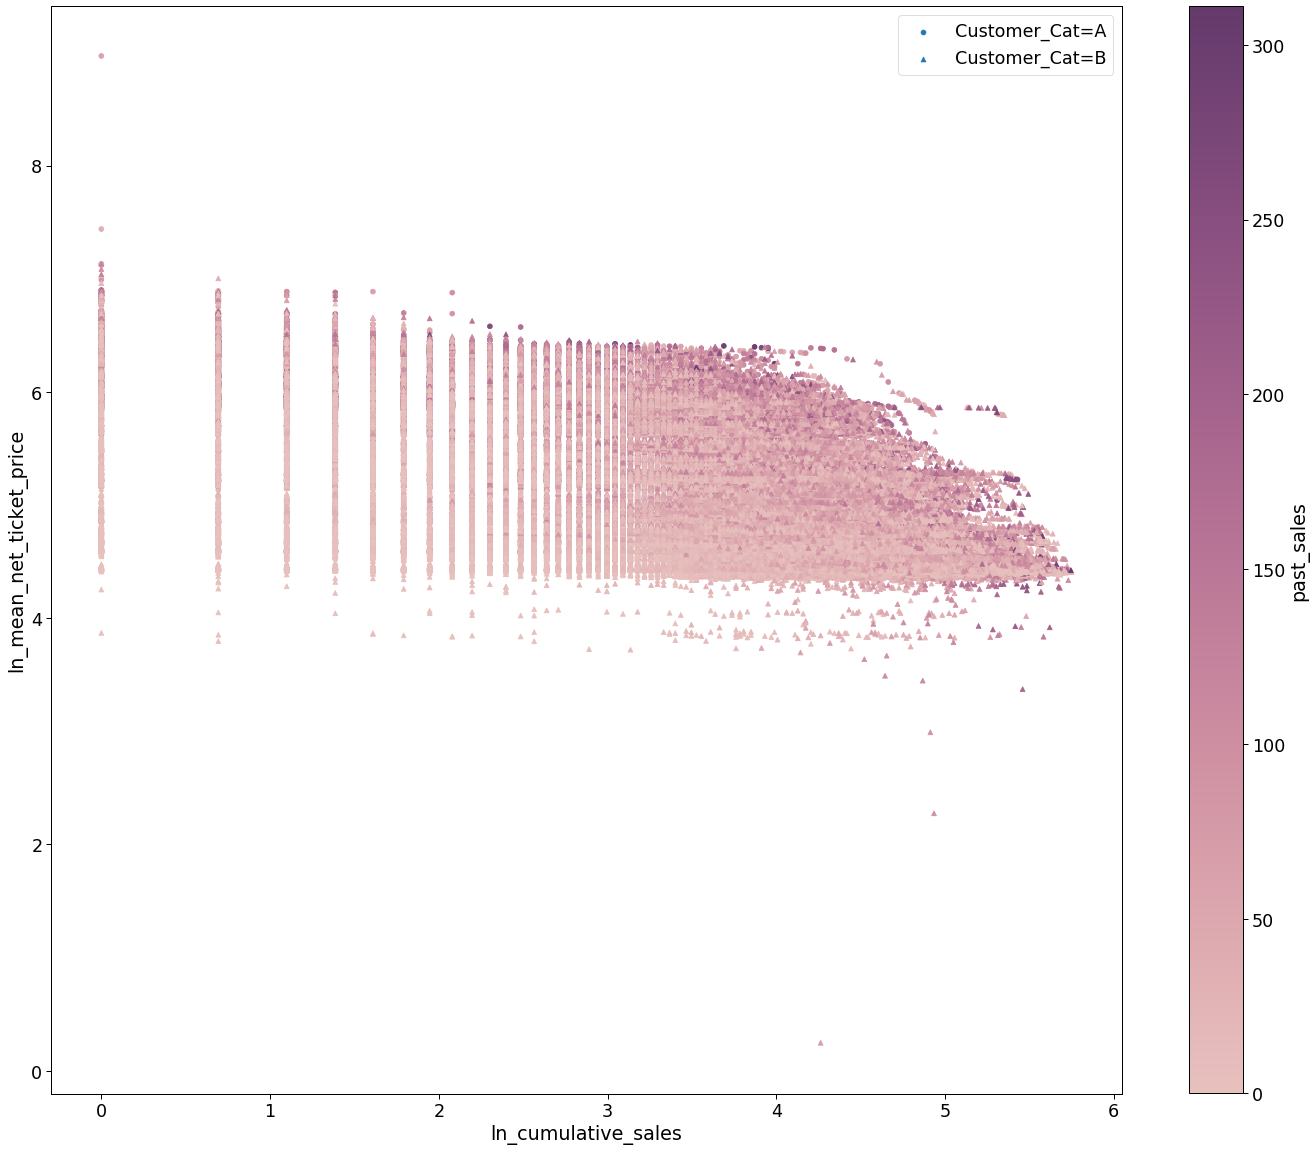

In [172]:
plt.figure(figsize=(24,20))
sns.set_context("paper", font_scale=2)  
marker_dict = {'A':'o','B':'^'}
groups  = df.groupby('Customer_Cat')
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)

for name, group in groups:
    plt.scatter(group['ln_cumulative_sales'], group['ln_mean_net_ticket_price'], c = group.past_sales, cmap = cmap,marker=marker_dict[name],label = 'Customer_Cat=' + str(name))
cbar = plt.colorbar()
cbar.set_label('past_sales')
plt.xlabel('ln_cumulative_sales')
plt.ylabel('ln_mean_net_ticket_price')
plt.legend()

plt.savefig('scatter_plot.jpg')

## Calculating the reduced forms

In [174]:
# price
price_reduced_form = ols('ln_mean_net_ticket_price ~ past_sales', df).fit()
price_reduced_form.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Results: Ordinary least squares
============================================================================
Model:              OLS                      Adj. R-squared:     0.072      
Dependent Variable: ln_mean_net_ticket_price AIC:                371381.4546
Date:               2020-09-22 23:33         BIC:                371401.9614
No. Observations:   209697                   Log-Likelihood:     -1.8569e+05
Df Model:           1                        F-statistic:        1.631e+04  
Df Residuals:       209695                   Prob (F-statistic): 0.00       
R-squared:          0.072                    Scale:              0.34409    
-------------------------------------------------------------------------------
                  Coef.     Std.Err.        t        P>|t|     [0.025    0.975]
-------------------------------------------------------------------------------
Intercept         5.0753      0.0019    2707.0252    0.0000    5.0716    5.0790
past_sales        0.0033      0.0000     127.6935    0.0000    0.0032    0.0033
----------------------------------------------------------------------------
Omnibus:               57476.330         Durbin-Watson:            0.612    
Prob(Omnibus):         0.000             Jarque-Bera (JB):         12658.834
Skew:                  0.319             Prob(JB):                 0.000    
Kurtosis:              1.979             Condition No.:            107      
============================================================================

"""

In [173]:
# demand
demand_reduced_form = ols('ln_cumulative_sales ~ past_sales', df).fit()
demand_reduced_form.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: Ordinary least squares
=======================================================================
Model:              OLS                 Adj. R-squared:     0.000      
Dependent Variable: ln_cumulative_sales AIC:                673750.9154
Date:               2020-09-22 23:32    BIC:                673771.4222
No. Observations:   209697              Log-Likelihood:     -3.3687e+05
Df Model:           1                   F-statistic:        73.64      
Df Residuals:       209695              Prob (F-statistic): 9.43e-18   
R-squared:          0.000               Scale:              1.4551     
--------------------------------------------------------------------------
              Coef.     Std.Err.       t        P>|t|     [0.025    0.975]
--------------------------------------------------------------------------
Intercept     3.2970      0.0039    855.1356    0.0000    3.2894    3.3045
past_sales    0.0005      0.0001      8.5814    0.0000    0.0003    0.0006
-----------------------------------------------------------------------
Omnibus:              16610.299       Durbin-Watson:          0.740    
Prob(Omnibus):        0.000           Jarque-Bera (JB):       20854.056
Skew:                 -0.766          Prob(JB):               0.000    
Kurtosis:             3.197           Condition No.:          107      
=======================================================================

"""

In [187]:
# structural
structural_form = ols('ln_cumulative_sales ~ ln_mean_net_ticket_price', df).fit()
structural_form.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Ordinary least squares
==========================================================================
Model:               OLS                  Adj. R-squared:      0.370      
Dependent Variable:  ln_cumulative_sales  AIC:                 577074.8087
Date:                2020-09-22 23:40     BIC:                 577095.3156
No. Observations:    209697               Log-Likelihood:      -2.8854e+05
Df Model:            1                    F-statistic:         1.229e+05  
Df Residuals:        209695               Prob (F-statistic):  0.00       
R-squared:           0.370                Scale:               0.91765    
--------------------------------------------------------------------------
                          Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                 9.6445   0.0182  531.2104 0.0000  9.6090  9.6801
ln_mean_net_ticket_price -1.2044   0.0034 -350.6219 0.0000 -1.2112 -1.1977
--------------------------------------------------------------------------
Omnibus:               30173.219        Durbin-Watson:           0.512    
Prob(Omnibus):         0.000            Jarque-Bera (JB):        48408.452
Skew:                  -0.997           Prob(JB):                0.000    
Kurtosis:              4.250            Condition No.:           47       
==========================================================================

"""

In [188]:
# get price predictions
predicted_mean_net_ticket_price = price_reduced_form.predict(df[['past_sales']])

In [189]:
predicted_mean_net_ticket_price[:6]

0    5.075276
1    5.075276
2    5.075276
3    5.088326
4    5.091589
5    5.075276
dtype: float64

In [190]:
predicted_mean_net_ticket_price.tail()

209692    5.081801
209693    5.094851
209694    5.107902
209695    5.114427
209696    5.075276
dtype: float64

In [191]:
df['pred_mean_net_ticket_price'] = predicted_mean_net_ticket_price

In [192]:
struc_2sls_form = ols('ln_cumulative_sales ~ pred_mean_net_ticket_price', df).fit()
struc_2sls_form.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: Ordinary least squares
=======================================================================
Model:              OLS                 Adj. R-squared:     0.000      
Dependent Variable: ln_cumulative_sales AIC:                673750.9154
Date:               2020-09-22 23:41    BIC:                673771.4222
No. Observations:   209697              Log-Likelihood:     -3.3687e+05
Df Model:           1                   F-statistic:        73.64      
Df Residuals:       209695              Prob (F-statistic): 9.43e-18   
R-squared:          0.000               Scale:              1.4551     
-----------------------------------------------------------------------
                           Coef.  Std.Err.    t    P>|t|  [0.025 0.975]
-----------------------------------------------------------------------
Intercept                  2.5956   0.0846 30.6840 0.0000 2.4298 2.7614
pred_mean_net_ticket_price 0.1382   0.0161  8.5814 0.0000 0.1066 0.1698
-----------------------------------------------------------------------
Omnibus:              16610.299       Durbin-Watson:          0.740    
Prob(Omnibus):        0.000           Jarque-Bera (JB):       20854.056
Skew:                 -0.766          Prob(JB):               0.000    
Kurtosis:             3.197           Condition No.:          175      
=======================================================================

"""